# Yelp Review Classification

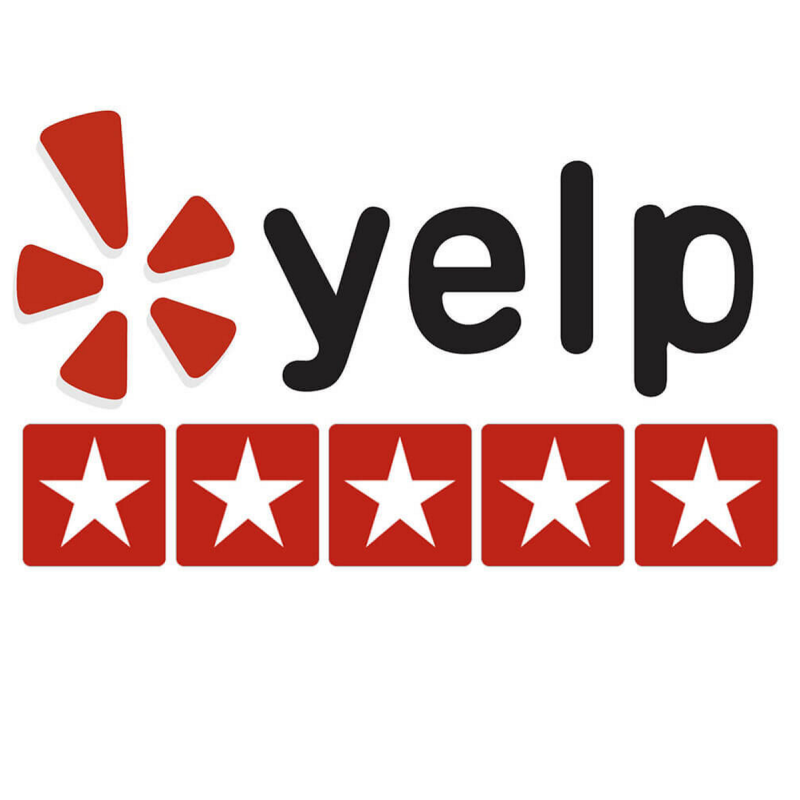

* In this project Natural Language Processing(NLP) strategies will be used to analyze Yelp reviews data.
* Yelp is an app that provide a crowd-sourced review forum to business and services. The app is used publish crowd-sourced reviews about businesses.
* Number of 'stars' indicate the business rating given by a customer, ranging from 1 to 5. 
* 'Cool', 'Useful', 'Funny' indicate the number of cool votes given by other Yelp Users.

## Import Libraries

In [100]:
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from pandas_profiling import ProfileReport

# Libraries for NLP
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    GridSearchCV)

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier, 
    VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix,
    balanced_accuracy_score, 
    classification_report, 
    plot_confusion_matrix)

# Handling imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import (BalancedBaggingClassifier, 
                              EasyEnsembleClassifier, 
                              RUSBoostClassifier, 
                              BalancedRandomForestClassifier)
# Metrcs for imbalanced data
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

# Counter
from collections import Counter

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

from sklearn import set_config
set_config(display="text")

In [4]:
# Function for clearing messages from punctuation marks and stopwords.
def message_cleaning(message):
    test_punc_removed = [char for char in message if char not in string.punctuation]
    test_punc_removed_join = ''.join(test_punc_removed)
    test_punc_removed_join_cleaned = [word for word in test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return test_punc_removed_join_cleaned

# Function to run create grid search model.
def grid_search_model(model, param_grid, cv):
    grid_search = GridSearchCV(model, param_grid, cv = cv, n_jobs = -1, scoring = 'roc_auc')
    return grid_search

## Load dataset

In [5]:
yelp_df = pd.read_csv('data/yelp.csv')

In [6]:
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [7]:
yelp_df.tail()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
9995,VY_tvNUCCXGXQeSvJl757Q,2012-07-28,Ubyfp2RSDYW0g7Mbr8N3iA,3,First visit...Had lunch here today - used my G...,review,_eqQoPtQ3e3UxLE4faT6ow,1,2,0
9996,EKzMHI1tip8rC1-ZAy64yg,2012-01-18,2XyIOQKbVFb6uXQdJ0RzlQ,4,Should be called house of deliciousness!\n\nI ...,review,ROru4uk5SaYc3rg8IU7SQw,0,0,0
9997,53YGfwmbW73JhFiemNeyzQ,2010-11-16,jyznYkIbpqVmlsZxSDSypA,4,I recently visited Olive and Ivy for business ...,review,gGbN1aKQHMgfQZkqlsuwzg,0,0,0
9998,9SKdOoDHcFoxK5ZtsgHJoA,2012-12-02,5UKq9WQE1qQbJ0DJbc-B6Q,2,My nephew just moved to Scottsdale recently so...,review,0lyVoNazXa20WzUyZPLaQQ,0,0,0
9999,pF7uRzygyZsltbmVpjIyvw,2010-10-16,vWSmOhg2ID1MNZHaWapGbA,5,4-5 locations.. all 4.5 star average.. I think...,review,KSBFytcdjPKZgXKQnYQdkA,0,0,0


In [8]:
yelp_df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [9]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


## Data Visualization

In [10]:
# Using ProfileReport

profile = ProfileReport (yelp_df, title = 'Yelp_review', explorative = True, 
                         plot = {'correlation': {'annot': True}}, 
                         html = {'style': {'full_width': True }}) 

profile.to_file("yelp_review_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
yelp_df['length'] = yelp_df['text'].apply(len)
yelp_df.head(10)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
5,-yxfBYGB6SEqszmxJxd97A,2007-12-13,m2CKSsepBCoRYWxiRUsxAg,4,"Quiessence is, simply put, beautiful. Full wi...",review,sqYN3lNgvPbPCTRsMFu27g,4,3,1,2094
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565
7,hW0Ne_HTHEAgGF1rAdmR-g,2012-07-12,JL7GXJ9u4YMx7Rzs05NfiQ,4,"Luckily, I didn't have to travel far to make m...",review,1ieuYcKS7zeAv_U15AB13A,0,1,0,274
8,wNUea3IXZWD63bbOQaOH-g,2012-08-17,XtnfnYmnJYi71yIuGsXIUA,4,Definitely come for Happy hour! Prices are ama...,review,Vh_DlizgGhSqQh4qfZ2h6A,0,0,0,349
9,nMHhuYan8e3cONo3PornJA,2010-08-11,jJAIXA46pU1swYyRCdfXtQ,5,Nobuo shows his unique talents with everything...,review,sUNkXg8-KFtCMQDV6zRzQg,0,1,0,186


<AxesSubplot:ylabel='Frequency'>

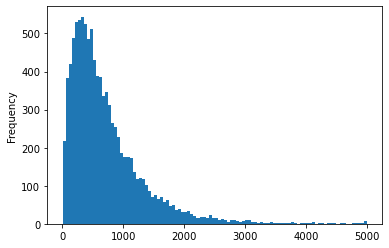

In [12]:
yelp_df['length'].plot(bins = 100, kind = 'hist')

In [13]:
yelp_df.length.describe()

count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: length, dtype: float64

In [14]:
yelp_df[yelp_df['length'] == 4997]['text'].iloc[0]

'In our continuing quest to identify cool, locally owned places to eat and/or drink, Caroline and I auditioned Vintage 95 last night. \n\nBefore I go further, understand that whenever I go out for eats or drinks, I have  in  mind a Platonic Ideal of the Bar/Pub/Eatery I most want to frequent. I\'m on a constant quest to find that  Ideal expressed in Real Life. \n\nVintage 95 isn\'t quite there, but it\'s damn close. If I ever give something Five Stars, you\'ll know it has pegged my Platonic Ideal. Anyway...\n\nThe plan last night was for drinks. No plans for food, just Adult Beverages and warm conversation. But it turned into more.\n\nThe location in downtown Chandler is terrific for us. The owners have created a very fine visual experience - leather, stone, dark woods, good lighting. And they don\'t have the music turned up so loud that you CANNOT HAVE A CONVERSATION. This is one of my pet peeves. If I want to stare at people move their mouths while enduring an aural assault, I\'ll st

In [15]:
yelp_df[yelp_df['length'] == 1]['text'].iloc[0]

'X'

In [16]:
yelp_df[yelp_df['length'] == 710]['text'].iloc[0]

"I went here for lunch a couple of weeks ago with my bosses. It was packed on a Friday - we sat at the bar and our cook was fantastic! We got to sit and chat with him while he worked away at the orders. I had the chicken pesto pasty and it was wonderful! the bread used is similar to a pastry dough type...but not as sweet. The pasty was so filling, I could barely finish it.\n\nMy bosses have been there before and have always wanted to try the peanut butter and jelly pasty - so we all split it as dessert and it was so good. They put bananas in it and drizzle jelly over the whole pasty. It's definitely rich and gooey. \n\nI would totally go back here again and have told my friends about it too! Amazing place."

In [17]:
# Analysis of date

yelp_df['month'] = pd.DatetimeIndex(yelp_df['date']).month
yelp_df['weekday'] = pd.DatetimeIndex(yelp_df['date']).weekday
yelp_df['year'] = pd.DatetimeIndex(yelp_df['date']).year

yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,month,weekday,year
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889,1,2,2011
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345,7,2,2011
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76,6,3,2012
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419,5,3,2010
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469,1,3,2012


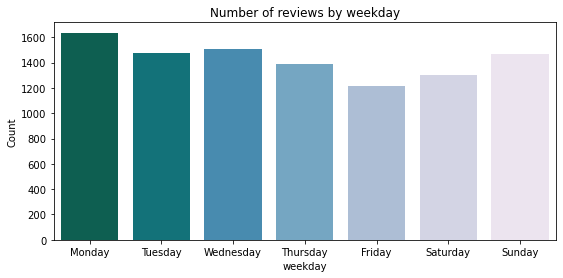

In [18]:
plt.figure(figsize = (9, 4))
sns.countplot(x = yelp_df['weekday'], data = yelp_df, palette = 'PuBuGn_r')
plt.xticks(range(7), 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split())
plt.ylabel('Count')
plt.title('Number of reviews by weekday')
plt.show()

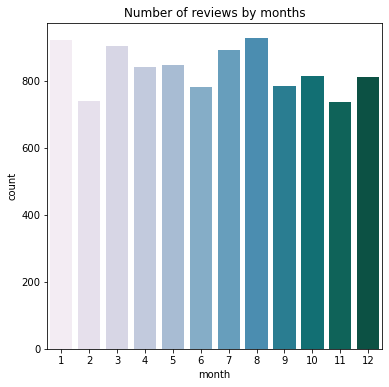

In [19]:
plt.figure(figsize = (6, 6))
sns.countplot(x = 'month', data = yelp_df, palette = 'PuBuGn')
plt.title('Number of reviews by months')
plt.show()

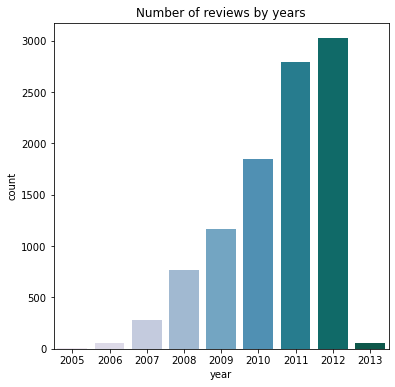

In [20]:
plt.figure(figsize = (6, 6))
sns.countplot(x = 'year', data = yelp_df, palette = 'PuBuGn')
plt.title('Number of reviews by years')
plt.show()

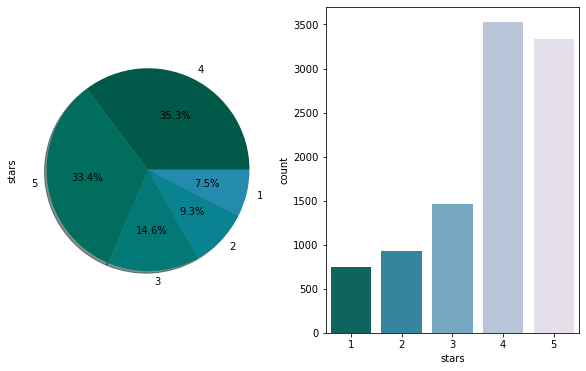

In [23]:
# Explore 'stars'
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
colors = sns.color_palette('PuBuGn_r', len(yelp_df.columns))
yelp_df['stars'].value_counts().plot.pie(shadow = True, autopct = '%1.1f%%', colors = colors)

plt.subplot(1, 2, 2)
sns.countplot(x = 'stars', data = yelp_df, palette = 'PuBuGn_r')
    
plt.show()

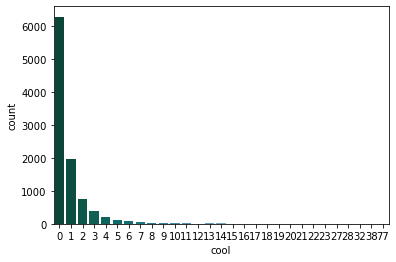

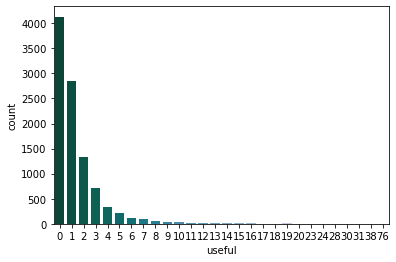

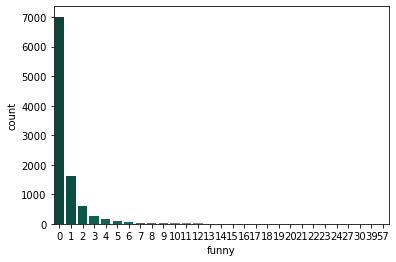

In [24]:
# Explore 'cool', 'useful', 'funny'

for col in ['cool', 'useful', 'funny']:
    fig = sns.countplot(x = col, data = yelp_df, palette = 'PuBuGn_r')
    plt.show()

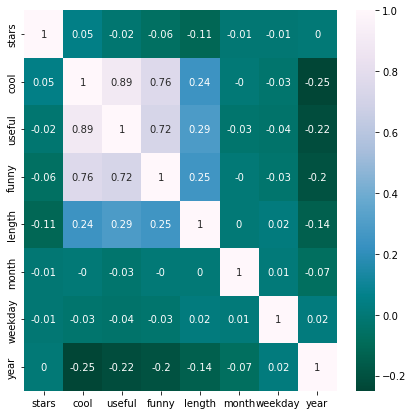

In [25]:
corr = yelp_df.corr().round(2)
fig = plt.figure(figsize = (7, 7))
sns.heatmap(corr, annot = True, cmap = 'PuBuGn_r')
plt.show()

'cool', 'funny', 'useful' are correlated with each other and correspondingly the 'length' of text is also the correlation index of text length is also almost the same for them

In [26]:
#Create new df

yelp_df_1 = yelp_df[yelp_df['stars'] == 1]
yelp_df_5 = yelp_df[yelp_df['stars'] == 5]

In [27]:
yelp_df_1.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,month,weekday,year
23,IJ0o6b8bJFAbG6MjGfBebQ,2010-09-05,Dx9sfFU6Zn0GYOckijom-g,1,U can go there n check the car out. If u wanna...,review,zRlQEDYd_HKp0VS3hnAffA,0,1,1,594,9,6,2010
31,vvA3fbps4F9nGlAEYKk_sA,2012-05-04,S9OVpXat8k5YwWCn6FAgXg,1,Disgusting! Had a Groupon so my daughter and ...,review,8AMn6644NmBf96xGO3w6OA,0,1,0,361,5,4,2012
35,o1GIYYZJjM6nM03fQs_uEQ,2011-11-30,ApKbwpYJdnhhgP4NbjQw2Q,1,"I've eaten here many times, but none as bad as...",review,iwUN95LIaEr75TZE_JC6bg,0,4,3,1198,11,2,2011
61,l4vBbCL9QbGiwLuLKwD_bA,2011-11-22,DJVxOfj2Rw9zklC9tU3i1w,1,I have always been a fan of Burlington's deals...,review,EPROVap0M19Y6_4uf3eCmQ,0,0,0,569,11,1,2011
64,CEswyP-9SsXRNLR9fFGKKw,2012-05-19,GXj4PNAi095-q9ynPYH3kg,1,Another night meeting friends here. I have to...,review,MjLAe48XNfYlTeFYca5gMw,0,1,2,498,5,5,2012


In [28]:
yelp_df_5.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,month,weekday,year
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889,1,2,2011
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345,7,2,2011
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419,5,3,2010
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469,1,3,2012
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565,2,4,2010


In [29]:
yelp_df_1_5 = pd.concat([yelp_df_1, yelp_df_5])

In [30]:
yelp_df_1_5.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,length,month,weekday,year
23,IJ0o6b8bJFAbG6MjGfBebQ,2010-09-05,Dx9sfFU6Zn0GYOckijom-g,1,U can go there n check the car out. If u wanna...,review,zRlQEDYd_HKp0VS3hnAffA,0,1,1,594,9,6,2010
31,vvA3fbps4F9nGlAEYKk_sA,2012-05-04,S9OVpXat8k5YwWCn6FAgXg,1,Disgusting! Had a Groupon so my daughter and ...,review,8AMn6644NmBf96xGO3w6OA,0,1,0,361,5,4,2012
35,o1GIYYZJjM6nM03fQs_uEQ,2011-11-30,ApKbwpYJdnhhgP4NbjQw2Q,1,"I've eaten here many times, but none as bad as...",review,iwUN95LIaEr75TZE_JC6bg,0,4,3,1198,11,2,2011
61,l4vBbCL9QbGiwLuLKwD_bA,2011-11-22,DJVxOfj2Rw9zklC9tU3i1w,1,I have always been a fan of Burlington's deals...,review,EPROVap0M19Y6_4uf3eCmQ,0,0,0,569,11,1,2011
64,CEswyP-9SsXRNLR9fFGKKw,2012-05-19,GXj4PNAi095-q9ynPYH3kg,1,Another night meeting friends here. I have to...,review,MjLAe48XNfYlTeFYca5gMw,0,1,2,498,5,5,2012


In [31]:
yelp_df_1_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 23 to 9999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  4086 non-null   object
 1   date         4086 non-null   object
 2   review_id    4086 non-null   object
 3   stars        4086 non-null   int64 
 4   text         4086 non-null   object
 5   type         4086 non-null   object
 6   user_id      4086 non-null   object
 7   cool         4086 non-null   int64 
 8   useful       4086 non-null   int64 
 9   funny        4086 non-null   int64 
 10  length       4086 non-null   int64 
 11  month        4086 non-null   int64 
 12  weekday      4086 non-null   int64 
 13  year         4086 non-null   int64 
dtypes: int64(8), object(6)
memory usage: 478.8+ KB


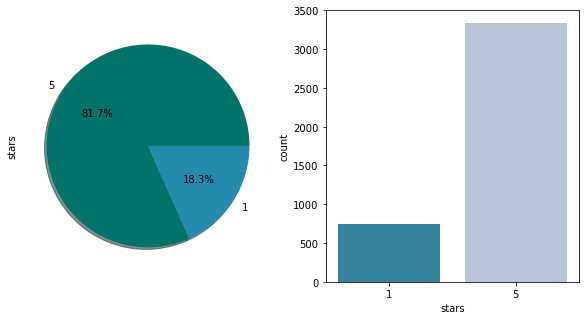

In [32]:
# Explore 'stars' in new df

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
colors = sns.color_palette('PuBuGn_r', len(col))
yelp_df_1_5['stars'].value_counts().plot.pie(shadow = True, autopct = '%1.1f%%', 
                                             colors = colors)

plt.subplot(1, 2, 2)
sns.countplot(x = 'stars', data = yelp_df_1_5, palette = 'PuBuGn_r')
    
plt.show()

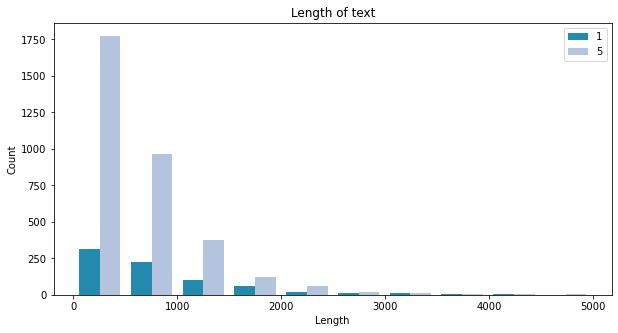

In [33]:
# Length of text

one_star = yelp_df_1_5[yelp_df_1_5['stars'] == 1]
five_stars = yelp_df_1_5[yelp_df_1_5['stars'] == 5]

one_star_lengths = one_star['text'].str.len()
five_stars_lenghts = five_stars['text'].str.len()

plt.figure(figsize = (10, 5))
colors = sns.color_palette('PuBuGn_r', 2) 
plt.hist([one_star_lengths, five_stars_lenghts], label = ['1', '5'], color = colors)
plt.title('Length of text')
plt.ylabel('Count')
plt.xlabel('Length')
plt.legend(loc = 'best')
plt.show()

### Word cloud feedback

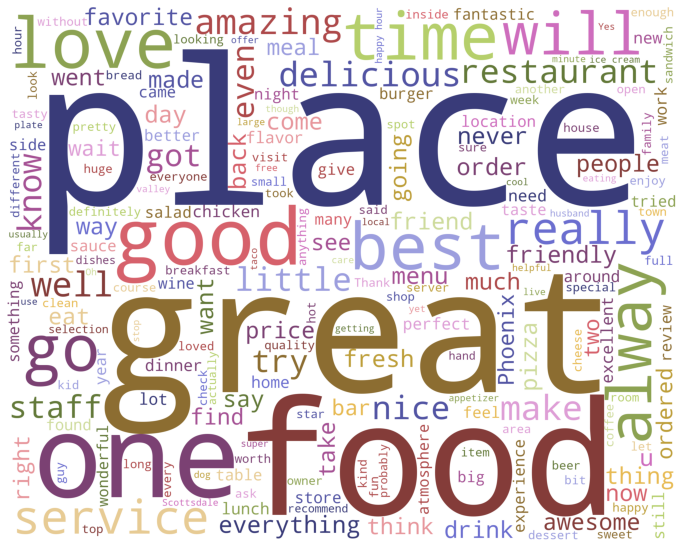

In [34]:
df_pos = yelp_df_1_5[yelp_df_1_5['stars'] == 5]['text']
wordcloud_pos = WordCloud(stopwords = STOPWORDS, background_color = 'white', width = 2500,
                      height = 2000, colormap = 'tab20b_r').generate(" ".join(df_pos))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

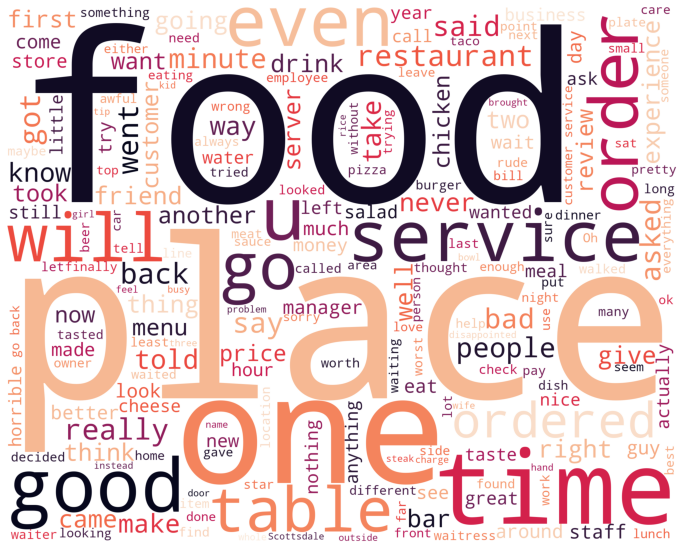

In [35]:
df_neg = yelp_df_1_5[yelp_df_1_5['stars'] == 1]['text']
wordcloud_neg = WordCloud(stopwords = STOPWORDS, background_color = 'white', width = 2500,
                      height = 2000, colormap = 'rocket_r').generate(" ".join(df_neg))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

Using WordCloud we can observe the most popular words for 1-star and 5-star reviews.

## Prepare the data for training / data cleaning

### Text preprocessing

In [36]:
vectorizer = TfidfVectorizer(analyzer = message_cleaning)
yelp_tfidvectorizer = vectorizer.fit_transform(yelp_df_1_5['text'])

In [37]:
print(vectorizer.get_feature_names_out())

['0' '00s' '01042012' ... 'École' 'éclairs' 'ém']


In [38]:
yelp_tfidvectorizer.shape

(4086, 26435)

### Divide the data into training and testing prior to training

In [39]:
label = yelp_df_1_5['stars'].values

In [40]:
X = yelp_tfidvectorizer
y = label

In [41]:
X.shape

(4086, 26435)

In [42]:
y.shape

(4086,)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [44]:
X_train.shape, X_test.shape

((3268, 26435), (818, 26435))

In [45]:
# RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits = 19, n_repeats = 5, random_state = 1)

In [46]:
# Create lists to store model scores
model_list = []
roc_auc_score_list = []
balanced_accuracy_list = []
geometric_mean_list = []

### Prepare dataset: undersampling & oversampling data

In [47]:
# Undersampling dataset
random_os = RandomOverSampler(random_state = 10)
X_train_os, y_train_os = random_os.fit_resample(X_train, y_train)

In [48]:
print(Counter(y_train_os))

Counter({5: 2659, 1: 2659})


In [49]:
# Oversampling dataset
random_us = RandomUnderSampler(random_state = 10)
X_train_us, y_train_us = random_us.fit_resample(X_train, y_train)

In [50]:
print(Counter(y_train_us))

Counter({1: 609, 5: 609})


## Model training & Searching hyperparameters with Grid-Search CV

### MultinomialNB

In [51]:
NB_classifier = MultinomialNB(alpha = 0.02)

In [52]:
NB_param_grid = { 
    'alpha': [0.01, 0.02, 0.1, 1]
}

In [53]:
NB_grid_search = grid_search_model(NB_classifier, NB_param_grid, cv)

In [54]:
%%timeit -r 1 -n 1
NB_grid_search.fit(X_train, y_train)

2.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [55]:
NB_grid_search.best_params_

{'alpha': 0.02}

In [56]:
y_train_pred_NB = NB_grid_search.predict(X_train)
y_test_pred_NB = NB_grid_search.predict(X_test)

print('Train set')
print('Multinomial Naive Bayes roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_NB)))

print('Test set')
print('Multinomial Naive Bayes roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_NB)))

Train set
Multinomial Naive Bayes roc-auc: 0.9852216748768473
Test set
Multinomial Naive Bayes roc-auc: 0.840181205225453


In [57]:
cm_NB_train = confusion_matrix(y_train, y_train_pred_NB)
cm_NB_train

array([[ 591,   18],
       [   0, 2659]], dtype=int64)

In [58]:
cm_NB_test = confusion_matrix(y_test, y_test_pred_NB)
cm_NB_test

array([[100,  40],
       [ 23, 655]], dtype=int64)

In [59]:
print(classification_report_imbalanced(y_test, y_test_pred_NB))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.81      0.71      0.97      0.76      0.83      0.67       140
          5       0.94      0.97      0.71      0.95      0.83      0.71       678

avg / total       0.92      0.92      0.76      0.92      0.83      0.70       818



In [60]:
# Store model scores to lists
model_list.append('Multinomial Naive Bayes')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_NB), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_NB), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_NB), 3))

### Multinomial Naive Bayes with oversampling

In [61]:
NB_classifier_os = MultinomialNB()

In [62]:
NB_grid_search_os = grid_search_model(NB_classifier_os, NB_param_grid, cv)

In [63]:
%%timeit -r 1 -n 1
NB_grid_search_os.fit(X_train_os, y_train_os)

609 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [64]:
NB_grid_search_os.best_params_

{'alpha': 0.02}

In [65]:
y_train_pred_NB_os = NB_grid_search_os.predict(X_train_os)
y_test_pred_NB_os = NB_grid_search_os.predict(X_test)

print('Train set')
print('Multinomial Naive Bayes with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_train_pred_NB_os)))

print('Test set')
print('Multinomial Naive Bayes with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_NB_os)))

Train set
Multinomial Naive Bayes with oversampling roc-auc: 0.995863106430989
Test set
Multinomial Naive Bayes with oversampling roc-auc: 0.8052043826380109


In [66]:
print(classification_report_imbalanced(y_test, y_test_pred_NB_os))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.80      0.64      0.97      0.71      0.79      0.60       140
          5       0.93      0.97      0.64      0.95      0.79      0.64       678

avg / total       0.91      0.91      0.70      0.91      0.79      0.64       818



In [67]:
# Store model scores to lists
model_list.append('Multinomial Naive Bayes (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_NB_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_NB_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_NB_os), 3))

### Multinomial Naive Bayes with undersampling

In [68]:
NB_classifier_us = MultinomialNB()

In [69]:
NB_grid_search_us = grid_search_model(NB_classifier_us, NB_param_grid, cv)

In [70]:
%%timeit -r 1 -n 1
NB_grid_search_us.fit(X_train_us, y_train_us)

282 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [71]:
NB_grid_search_us.best_params_

{'alpha': 0.1}

In [72]:
y_train_pred_NB_us = NB_grid_search_us.predict(X_train_us)
y_test_pred_NB_us = NB_grid_search_us.predict(X_test)

print('Train set')
print('Multinomial Naive Bayes with undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_train_pred_NB_us)))

print('Test set')
print('Multinomial Naive Bayes with undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_NB_us)))

Train set
Multinomial Naive Bayes with undersampling roc-auc: 0.9967159277504106
Test set
Multinomial Naive Bayes with undersampling roc-auc: 0.9022229245680573


In [73]:
print(classification_report_imbalanced(y_test, y_test_pred_NB_us))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.60      0.94      0.87      0.73      0.90      0.82       140
          5       0.98      0.87      0.94      0.92      0.90      0.81       678

avg / total       0.92      0.88      0.92      0.89      0.90      0.81       818



In [74]:
model_list.append('Multinomial Naive Bayes (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_NB_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_NB_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_NB_us), 3))

### Logistic Regression

In [75]:
LR = LogisticRegression(random_state = 0, class_weight = 'balanced', C = 0.01, max_iter = 200)

In [76]:
LR_param_grid = {
    'penalty': ['l1', 'l2'], 
    'solver': ['lbfgs', 'liblinear'], 
    'multi_class': ['auto', 'ovr', 'multinomial']
}

In [77]:
LR_grid_search = grid_search_model(LR, LR_param_grid, cv)

In [78]:
%%timeit -r 1 -n 1
LR_grid_search.fit(X_train, y_train)

4.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [79]:
LR_grid_search.best_params_

{'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

In [80]:
y_train_pred_LR = LR_grid_search.predict(X_train)
y_test_pred_LR = LR_grid_search.predict(X_test)

print('Train set')
print('Logistic Regression roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_LR)))

print('Test set')
print('Logistic Regression roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_LR)))

Train set
Logistic Regression roc-auc: 0.9308118599594524
Test set
Logistic Regression roc-auc: 0.8581963758954909


In [81]:
print(classification_report_imbalanced(y_test, y_test_pred_LR))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.70      0.79      0.93      0.74      0.86      0.72       140
          5       0.95      0.93      0.79      0.94      0.86      0.74       678

avg / total       0.91      0.91      0.81      0.91      0.86      0.74       818



In [82]:
model_list.append('Logistic Regression')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_LR), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_LR), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_LR), 3))

### Logistic Regression with oversampling

In [83]:
LR_os = LogisticRegression(random_state = 0, max_iter = 200, penalty = 'l2', solver = 'liblinear', C = 0.01, 
                             multi_class = 'multinomial')

In [84]:
LR_os_grid_search = grid_search_model(LR_os, LR_param_grid, cv)

In [85]:
%%timeit -r 1 -n 1
LR_os_grid_search.fit(X_train_os, y_train_os)

6.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [86]:
LR_os_grid_search.best_params_

{'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

In [87]:
y_train_pred_LR_os = LR_os_grid_search.predict(X_train_os)
y_test_pred_LR_os = LR_os_grid_search.predict(X_test)

print('Train set')
print('Logistic Regression with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_train_pred_LR_os)))

print('Test set')
print('Logistic Regression with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_LR_os)))

Train set
Logistic Regression with oversampling roc-auc: 0.9332455810455058
Test set
Logistic Regression with oversampling roc-auc: 0.8625052675937632


In [88]:
print(classification_report_imbalanced(y_test, y_test_pred_LR_os))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.71      0.79      0.93      0.75      0.86      0.73       140
          5       0.96      0.93      0.79      0.94      0.86      0.75       678

avg / total       0.91      0.91      0.82      0.91      0.86      0.75       818



In [89]:
# Save the model results into lists
model_list.append('Logistic Regression (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_LR_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_LR_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_LR_os), 3))

### Logistic Regression with undersampling

In [90]:
LR_us = LogisticRegression(random_state = 0, max_iter = 200, penalty = 'l2', solver = 'liblinear', C = 0.01, 
                             multi_class = 'multinomial')

In [91]:
LR_us_grid_search = grid_search_model(LR_us, LR_param_grid, cv)

In [92]:
%%timeit -r 1 -n 1
LR_us_grid_search.fit(X_train_us, y_train_us)

3.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
LR_us_grid_search.best_params_

{'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

In [94]:
y_train_pred_LR_us = LR_us_grid_search.predict(X_train_us)
y_test_pred_LR_us = LR_us_grid_search.predict(X_test)

print('Train set')
print('Logistic Regression with undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_train_pred_LR_us)))

print('Test set')
print('Logistic Regression with undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_LR_us)))

Train set
Logistic Regression with undersampling roc-auc: 0.9474548440065682
Test set
Logistic Regression with undersampling roc-auc: 0.8634007585335017


In [95]:
print(classification_report_imbalanced(y_test, y_test_pred_LR_us))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.63      0.83      0.90      0.71      0.86      0.74       140
          5       0.96      0.90      0.83      0.93      0.86      0.75       678

avg / total       0.90      0.89      0.84      0.89      0.86      0.75       818



In [96]:
# Save the model results into lists
model_list.append('Logistic Regression (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_LR_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_LR_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_LR_us), 3))

### Confusion matrix: Logistic Regression

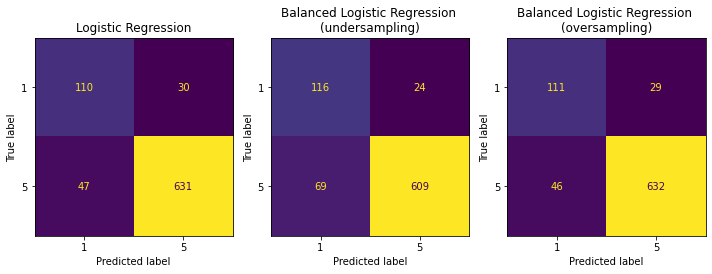

In [97]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(LR_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Logistic Regression")

plot_confusion_matrix(LR_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Logistic Regression \n(undersampling)")

plot_confusion_matrix(LR_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Logistic Regression \n(oversampling)")

fig.tight_layout()

### BaggingClassifier

In [101]:
bag_clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 4,
                            class_weight = 'balanced', random_state = 10), 
                            n_estimators = 50, random_state = 0)

In [102]:
bag_clf_param_grid = {
     'n_estimators': [30, 40, 50], 
}

In [103]:
bag_clf_grid_search = grid_search_model(bag_clf, bag_clf_param_grid, cv)

In [104]:
%%timeit -r 1 -n 1
bag_clf_grid_search.fit(X_train, y_train)

1min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [105]:
bag_clf_grid_search.best_params_

{'n_estimators': 50}

In [106]:
y_train_pred_bag = bag_clf_grid_search.predict(X_train)
y_test_pred_bag = bag_clf_grid_search.predict(X_test)

print('Train set')
print('Bagging Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_bag)))

print('Test set')
print('Bagging Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_bag)))

Train set
Bagging Classifier roc-auc: 0.7872998170232028
Test set
Bagging Classifier roc-auc: 0.7680362410450907


In [107]:
print(classification_report_imbalanced(y_test, y_test_pred_bag))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.36      0.84      0.69      0.51      0.76      0.59       140
          5       0.96      0.69      0.84      0.80      0.76      0.58       678

avg / total       0.85      0.72      0.82      0.75      0.76      0.58       818



In [108]:
model_list.append('Bagging Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_bag), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_bag), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_bag), 3))

### BaggingClassifier with oversampling

In [109]:
bag_os = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 4), n_estimators = 100)

In [110]:
bag_os_grid_search = grid_search_model(bag_os, bag_clf_param_grid, cv)

In [111]:
%%timeit -r 1 -n 1
bag_os_grid_search.fit(X_train_os, y_train_os)

1min 35s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [112]:
bag_os_grid_search.best_params_

{'n_estimators': 50}

In [113]:
y_train_pred_bag_os = bag_clf_grid_search.predict(X_train_os)
y_test_pred_bag_os = bag_clf_grid_search.predict(X_test)

print('Train set')
print('Bagging Classifier with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_train_pred_bag_os)))

print('Test set')
print('Bagging Classifier with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_bag_os)))

Train set
Bagging Classifier with oversampling roc-auc: 0.7916509966152689
Test set
Bagging Classifier with oversampling roc-auc: 0.7680362410450907


In [114]:
print(classification_report_imbalanced(y_test, y_test_pred_bag_os))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.36      0.84      0.69      0.51      0.76      0.59       140
          5       0.96      0.69      0.84      0.80      0.76      0.58       678

avg / total       0.85      0.72      0.82      0.75      0.76      0.58       818



In [115]:
model_list.append('Bagging Classifier (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_bag_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_bag_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_bag_os), 3))

### BaggingClassifier with undersampling

In [116]:
bag_us = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth = 4), n_estimators = 50)

In [117]:
bag_us_grid_search = grid_search_model(bag_us, bag_clf_param_grid, cv)

In [118]:
%%timeit -r 1 -n 1
bag_us_grid_search.fit(X_train_us, y_train_us)

27.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [119]:
bag_us_grid_search.best_params_

{'n_estimators': 50}

In [120]:
y_train_pred_bag_us = bag_us_grid_search.predict(X_train_us)
y_test_pred_bag_us = bag_us_grid_search.predict(X_test)

print('Train set')
print('Bagging Classifier with undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_train_pred_bag_us)))

print('Test set')
print('Bagging Classifier with undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_bag_us)))

Train set
Bagging Classifier with undersampling roc-auc: 0.7848932676518884
Test set
Bagging Classifier with undersampling roc-auc: 0.7619469026548672


In [121]:
print(classification_report_imbalanced(y_test, y_test_pred_bag_us))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.33      0.90      0.62      0.48      0.75      0.58       140
          5       0.97      0.62      0.90      0.76      0.75      0.55       678

avg / total       0.86      0.67      0.85      0.71      0.75      0.55       818



In [122]:
# Save the model results into lists
model_list.append('Bagging Classifier (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_bag_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_bag_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_bag_us), 3))

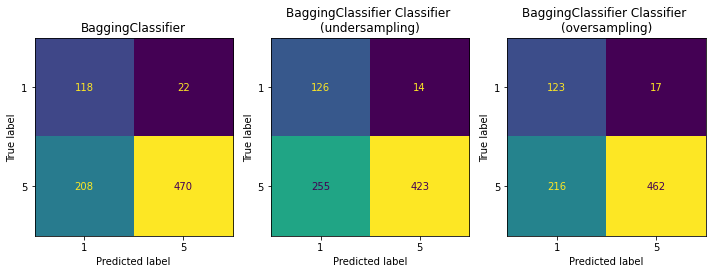

In [123]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(bag_clf_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("BaggingClassifier")

plot_confusion_matrix(bag_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("BaggingClassifier Classifier \n(undersampling)")

plot_confusion_matrix(bag_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("BaggingClassifier Classifier \n(oversampling)")

fig.tight_layout()

### Random Forest Classifier

In [124]:
rf = RandomForestClassifier(n_estimators = 300, max_depth = 3, class_weight = 'balanced')

In [125]:
rf_param_grid = {   
    'n_estimators': [200, 300, 400],
    'max_depth': [2, 3],
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'min_samples_split': [2, 3, 4]
}

In [126]:
rf_grid_search = grid_search_model(rf, rf_param_grid, cv)

In [127]:
%%timeit -r 1 -n 1
rf_grid_search.fit(X_train, y_train)

3min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [128]:
rf_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 400}

In [129]:
y_train_pred_rf = rf_grid_search.predict(X_train)
y_test_pred_rf = rf_grid_search.predict(X_test)

print('Train set')
print('Random Forest Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_rf)))

print('Test set')
print('Random Forest Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_rf)))

Train set
Random Forest Classifier roc-auc: 0.8552411458806136
Test set
Random Forest Classifier roc-auc: 0.7932890855457227


In [130]:
print(classification_report_imbalanced(y_test, y_test_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.68      0.65      0.94      0.66      0.78      0.59       140
          5       0.93      0.94      0.65      0.93      0.78      0.63       678

avg / total       0.89      0.89      0.70      0.89      0.78      0.62       818



In [131]:
# Save the model results into lists
model_list.append('Random Forest Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_rf), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_rf), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_rf), 3))

### Random Forest Classifier with oversampling

In [132]:
rf_os = RandomForestClassifier(n_estimators = 300, max_depth = 3)

In [133]:
rf_os_grid_search = grid_search_model(rf_os, rf_param_grid, cv)

In [134]:
%%timeit -r 1 -n 1
rf_os_grid_search.fit(X_train_os, y_train_os)

3min 36s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [135]:
rf_os_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 400}

In [136]:
y_train_pred_rf_os = rf_os_grid_search.predict(X_train_os)
y_test_pred_rf_os = rf_os_grid_search.predict(X_test)

print('Train set')
print('Random Forest Classifier with oversampling roc-auc: {}'. format(roc_auc_score(y_train_os, y_train_pred_rf_os)))

print('Test set')
print('Random Forest Classifier with oversampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_rf_os)))

Train set
Random Forest Classifier with oversampling roc-auc: 0.8742008273787139
Test set
Random Forest Classifier with oversampling roc-auc: 0.8139801938474505


In [137]:
print(classification_report_imbalanced(y_test, y_test_pred_rf_os))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.69      0.69      0.94      0.69      0.80      0.63       140
          5       0.94      0.94      0.69      0.94      0.80      0.66       678

avg / total       0.89      0.89      0.73      0.89      0.80      0.66       818



In [138]:
# Save the model results into lists
model_list.append('Random Forest Classifier (oversampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_rf_os), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_rf_os), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_rf_os), 3))

### Random Forest Classifier with undersampling

In [139]:
rf_us = RandomForestClassifier(n_estimators = 300, max_depth = 3)

In [140]:
rf_us_grid_search = grid_search_model(rf_us, rf_param_grid, cv)

In [141]:
%%timeit -r 1 -n 1
rf_us_grid_search.fit(X_train_us, y_train_us)

2min 8s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [142]:
rf_us_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_split': 3,
 'n_estimators': 400}

In [143]:
y_train_pred_rf_us = rf_us_grid_search.predict(X_train_us)
y_test_pred_rf_us = rf_us_grid_search.predict(X_test)

print('Train set')
print('Random Forest Classifier with undersampling roc-auc: {}'. format(roc_auc_score(y_train_us, y_train_pred_rf_us)))

print('Test set')
print('Random Forest Classifier with undersampling roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_rf_us)))

Train set
Random Forest Classifier with undersampling roc-auc: 0.8825944170771758
Test set
Random Forest Classifier with undersampling roc-auc: 0.7930994521702486


In [144]:
print(classification_report_imbalanced(y_test, y_test_pred_rf_us))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.55      0.71      0.88      0.62      0.79      0.61       140
          5       0.94      0.88      0.71      0.91      0.79      0.63       678

avg / total       0.87      0.85      0.74      0.86      0.79      0.63       818



In [145]:
# Save the model results into lists
model_list.append('Random Forest Classifier (undersampling)')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_rf_us), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_rf_us), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_rf_us), 3))

### Confusion matrix: Random Forest Classifier

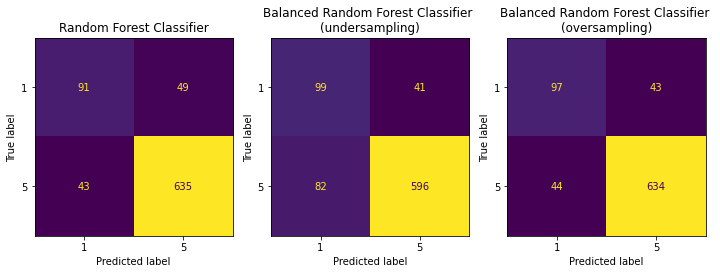

In [146]:
fig, axs = plt.subplots(ncols = 3, figsize = (10, 5))
plot_confusion_matrix(rf_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Random Forest Classifier")

plot_confusion_matrix(rf_us_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("Balanced Random Forest Classifier \n(undersampling)")

plot_confusion_matrix(rf_os_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Random Forest Classifier \n(oversampling)")

fig.tight_layout()

### Linear SVC

In [147]:
svc = LinearSVC(class_weight = 'balanced', C = 0.01)

In [148]:
svc_param_grid = {
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2'],
    'dual': [True, False]
    }

In [149]:
svc_grid_search = grid_search_model(svc, svc_param_grid, cv)

In [150]:
svc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=19, random_state=1),
             estimator=LinearSVC(C=0.01, class_weight='balanced'), n_jobs=-1,
             param_grid={'dual': [True, False],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [151]:
svc_grid_search.best_params_

{'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}

In [152]:
y_train_pred_svc = svc_grid_search.predict(X_train)
y_test_pred_svc = svc_grid_search.predict(X_test)

print('Train set')
print('LinearSVC roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_svc)))

print('Test set')
print('LinearSVC roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_svc)))

Train set
LinearSVC roc-auc: 0.9471448394429551
Test set
LinearSVC roc-auc: 0.8660766961651918


In [153]:
print(classification_report_imbalanced(y_test, y_test_pred_svc))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.71      0.80      0.93      0.75      0.86      0.74       140
          5       0.96      0.93      0.80      0.94      0.86      0.76       678

avg / total       0.92      0.91      0.82      0.91      0.86      0.75       818



Text(0.5, 1.0, 'SVC')

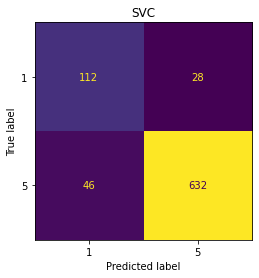

In [154]:
fig = plot_confusion_matrix(svc_grid_search, X_test, y_test, colorbar = False)
plt.title('SVC')

In [155]:
# Save the model results into lists
model_list.append('Linear SVC')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_svc), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_svc), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_svc), 3))

## Specific balanced algorithms from imbalanced-learn
### BalancedBaggingClassifier

In [156]:
bbag_clf = BalancedBaggingClassifier(base_estimator = DecisionTreeClassifier(
                                    max_depth = 4, 
                                    criterion = 'entropy'), 
                                    random_state = 0, n_estimators = 100)

In [157]:
bbag_clf_param_grid = {
     'n_estimators': [50, 100], 
}

In [158]:
bbag_clf_grid_search = grid_search_model(bbag_clf, bbag_clf_param_grid , cv)

In [159]:
%%timeit -r 1 -n 1
bbag_clf_grid_search.fit(X_train, y_train)

58.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [160]:
bbag_clf_grid_search.best_params_

{'n_estimators': 100}

In [161]:
y_train_pred_bbag = bbag_clf_grid_search.predict(X_train)
y_test_pred_bbag = bbag_clf_grid_search.predict(X_test)

print('Train set')
print('Balanced Bagging Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_bbag)))

print('Test set')
print('Balanced Bagging Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_bbag)))

Train set
Balanced Bagging Classifier roc-auc: 0.7861132158897717
Test set
Balanced Bagging Classifier roc-auc: 0.7888853771597134


In [162]:
cm_bbag_train = confusion_matrix(y_train, y_train_pred_bbag)
cm_bbag_train

array([[ 575,   34],
       [ 989, 1670]], dtype=int64)

In [163]:
cm_bbag_test = confusion_matrix(y_test, y_test_pred_bbag)
cm_bbag_test

array([[129,  11],
       [233, 445]], dtype=int64)

In [164]:
print(classification_report_imbalanced(y_test, y_test_pred_bbag))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.36      0.92      0.66      0.51      0.78      0.62       140
          5       0.98      0.66      0.92      0.78      0.78      0.59       678

avg / total       0.87      0.70      0.88      0.74      0.78      0.59       818



In [165]:
# Save the model results into lists
model_list.append('Balanced Bagging Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_bbag), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_bbag), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_bbag), 3))

### EasyEnsembleClassifier

In [175]:
base_estimator = AdaBoostClassifier(n_estimators = 20)

In [176]:
eec = EasyEnsembleClassifier(n_estimators = 50, base_estimator = base_estimator)

In [177]:
eec_param_grid = {
     'n_estimators': [20, 30, 40], 
}

In [178]:
eec_grid_search = grid_search_model(eec, eec_param_grid, cv)

In [179]:
%%timeit -r 1 -n 1
eec_grid_search.fit(X_train, y_train)

4min 54s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [180]:
eec_grid_search.best_params_

{'n_estimators': 40}

In [181]:
y_train_pred_eec = eec_grid_search.predict(X_train)
y_test_pred_eec = eec_grid_search.predict(X_test)

print('Train set')
print('Easy Ensemble Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_eec)))

print('Test set')
print('Easy Ensemble Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_eec)))

Train set
Easy Ensemble Classifier roc-auc: 0.8391857501647285
Test set
Easy Ensemble Classifier roc-auc: 0.8400021070375053


In [182]:
cm_eec_train = confusion_matrix(y_train, y_train_pred_eec)
cm_eec_train

array([[ 562,   47],
       [ 650, 2009]], dtype=int64)

In [183]:
cm_eec_test = confusion_matrix(y_test, y_test_pred_eec)
cm_eec_test

array([[127,  13],
       [154, 524]], dtype=int64)

In [184]:
print(classification_report_imbalanced(y_test, y_test_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.45      0.91      0.77      0.60      0.84      0.71       140
          5       0.98      0.77      0.91      0.86      0.84      0.69       678

avg / total       0.89      0.80      0.88      0.82      0.84      0.69       818



In [185]:
# Save the model results into lists
model_list.append('Easy Ensemble Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_eec), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_eec), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_eec), 3))

### RUSBoostClassifier

In [186]:
rusboost = RUSBoostClassifier(n_estimators = 50, base_estimator = base_estimator, 
                              learning_rate = 0.1)

In [187]:
rusboost_param_grid = {
     'n_estimators': [20, 30, 40, 50], 
}

In [188]:
rusboost_grid_search = grid_search_model(rusboost, rusboost_param_grid, cv)

In [189]:
%%timeit -r 1 -n 1
rusboost_grid_search.fit(X_train, y_train)

7min 56s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [190]:
rusboost_grid_search.best_params_

{'n_estimators': 50}

In [191]:
y_train_pred_rusb = rusboost_grid_search.predict(X_train)
y_test_pred_rusb = rusboost_grid_search.predict(X_test)

print('Train set')
print('Easy Ensemble Classifier roc-auc: {}'. format(roc_auc_score(y_train, y_train_pred_rusb)))

print('Test set')
print('Easy Ensemble Classifier roc-auc: {}'. format(roc_auc_score(y_test, y_test_pred_rusb)))

Train set
Easy Ensemble Classifier roc-auc: 0.8536516005683829
Test set
Easy Ensemble Classifier roc-auc: 0.8552570585756426


In [192]:
cm_rusboost_train = confusion_matrix(y_train, y_train_pred_rusb)
cm_rusboost_train

array([[ 570,   39],
       [ 608, 2051]], dtype=int64)

In [193]:
cm_rusboost_test = confusion_matrix(y_test, y_test_pred_rusb)
cm_rusboost_test

array([[129,  11],
       [143, 535]], dtype=int64)

In [194]:
print(classification_report_imbalanced(y_test, y_test_pred_rusb))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.47      0.92      0.79      0.63      0.85      0.74       140
          5       0.98      0.79      0.92      0.87      0.85      0.72       678

avg / total       0.89      0.81      0.90      0.83      0.85      0.72       818



In [195]:
# Save the model results into lists
model_list.append('RUSBoost Classifier')
roc_auc_score_list.append(round(roc_auc_score(y_test, y_test_pred_rusb), 3))
balanced_accuracy_list.append(round(balanced_accuracy_score(y_test, y_test_pred_rusb), 3))
geometric_mean_list.append(round(geometric_mean_score(y_test, y_test_pred_rusb), 3))

### Confusion matrix: classification from imbalanced-learn

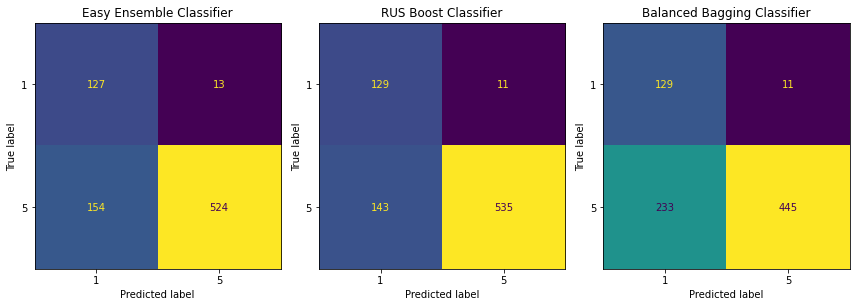

In [202]:
fig, axs = plt.subplots(ncols = 3, figsize = (12, 5))

plot_confusion_matrix(eec_grid_search, X_test, y_test, ax = axs[0], colorbar = False)
axs[0].set_title("Easy Ensemble Classifier")

plot_confusion_matrix(rusboost_grid_search, X_test, y_test, ax = axs[1], colorbar = False)
axs[1].set_title("RUS Boost Classifier")

plot_confusion_matrix(bbag_clf_grid_search, X_test, y_test, ax = axs[2], colorbar = False)
axs[2].set_title("Balanced Bagging Classifier")

fig.tight_layout()

## Results

In [203]:
model_results = pd.DataFrame({'Model': model_list, 
                             'roc_auc_score': roc_auc_score_list, 
                             'balanced_accuracy_score': balanced_accuracy_list, 
                             'geometric_mean_score': geometric_mean_list})
model_results

,Model,roc_auc_score,balanced_accuracy_score,geometric_mean_score
0,Multinomial Naive Bayes,0.840,0.840,0.831
1,Multinomial Naive Bayes (oversampling),0.805,0.805,0.789
2,Multinomial Naive Bayes (undersampling),0.902,0.902,0.902
3,Logistic Regression,0.858,0.858,0.855
4,Logistic Regression (oversampling),0.863,0.863,0.860
5,Logistic Regression (undersampling),0.863,0.863,0.863
6,Bagging Classifier,0.768,0.768,0.764
7,Bagging Classifier (oversampling),0.768,0.768,0.764
8,Bagging Classifier (undersampling),0.762,0.762,0.749
9,Random Forest Classifier,0.793,0.793,0.780


In [204]:
model_results.sort_values(by ='roc_auc_score', ascending = False)

,Model,roc_auc_score,balanced_accuracy_score,geometric_mean_score
2,Multinomial Naive Bayes (undersampling),0.902,0.902,0.902
12,Linear SVC,0.866,0.866,0.864
4,Logistic Regression (oversampling),0.863,0.863,0.860
5,Logistic Regression (undersampling),0.863,0.863,0.863
3,Logistic Regression,0.858,0.858,0.855
15,RUSBoost Classifier,0.855,0.855,0.853
0,Multinomial Naive Bayes,0.840,0.840,0.831
14,Easy Ensemble Classifier,0.840,0.840,0.837
10,Random Forest Classifier (oversampling),0.814,0.814,0.805
1,Multinomial Naive Bayes (oversampling),0.805,0.805,0.789


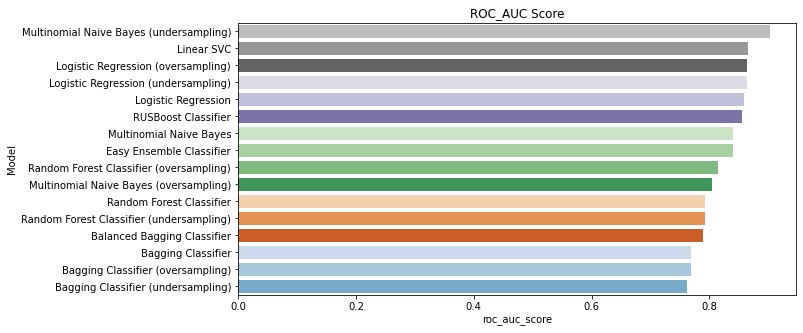

In [205]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='roc_auc_score', ascending = False), 
            x = 'roc_auc_score', y = 'Model', palette = 'tab20c_r')
plt.title("ROC_AUC Score")
plt.show()

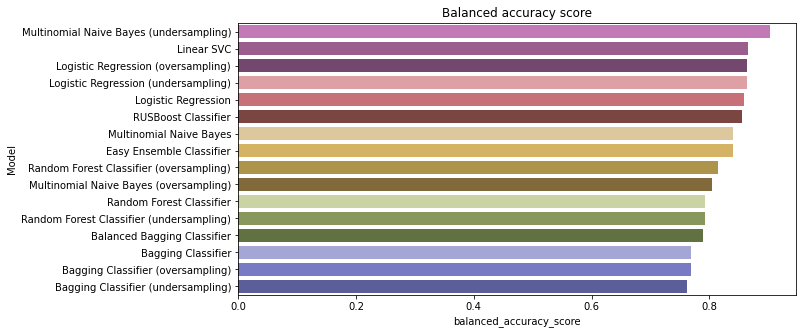

In [206]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='balanced_accuracy_score', ascending = False), 
            x = 'balanced_accuracy_score', y = 'Model', palette = 'tab20b_r')
plt.title("Balanced accuracy score")
plt.show()

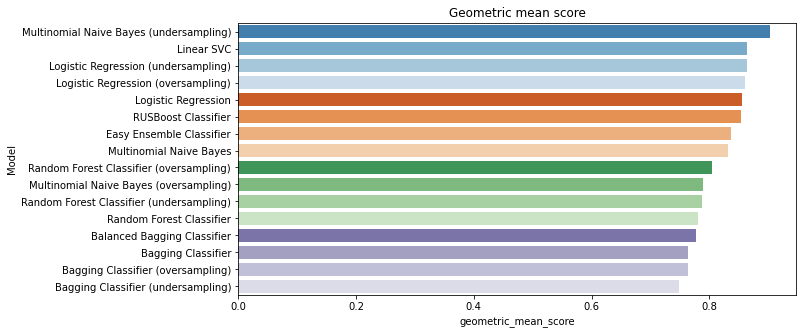

In [207]:
plt.figure(figsize=(10, 5))
sns.barplot(data = model_results.sort_values(by ='geometric_mean_score', ascending = False), 
            x = 'geometric_mean_score', y = 'Model', palette = 'tab20c')
plt.title("Geometric mean score")
plt.show()

### Testing review

In [208]:
testing_sample = [str(input("Enter review : "))]
testing_sample_vectorizer = vectorizer.transform(testing_sample)
test_predict = svc_grid_search.predict(testing_sample_vectorizer)
if test_predict == 1:
    print('\nNegative review')
else:
    print('\nPositive review')

Enter review : Went for brunch on Sunday, short wait for patio seating. When the server finally came to table, his only comment was “I’m overwhelmed,” He brought two glasses of water..we were a party of five. Order was taken and food was delivered in a timely fashion. Was good. The problem was customer service, we never received the bread/cake to enjoy while waiting, never had a drink refilled, after asking for jelly and ketchup, they were brought with the bill

Negative review


In [209]:
testing_sample = [str(input("Enter review : "))]
testing_sample_vectorizer = vectorizer.transform(testing_sample)
test_predict = svc_grid_search.predict(testing_sample_vectorizer)
if test_predict == 1:
    print('\nNegative review')
else:
    print('\nPositive review')

Enter review : I go to breakfast or lunch weekly with a group of older women. In addition to the really good food, I must say that our waitress today was so kind and patient, as the group tried to decide what they wanted and were talking non-stop. 🤪 My husband and I love dinner there as well. We are so fortunate to have this outstanding restaurant in our town of Eastham. It’s a gem.

Positive review


## Conclusion

- Yelp review dataset is very unbalanced (81.7% positives reviews vs 18.3% negative reviews).

- We used only preprocessed text with TF-IDF vectorizer in training models. In this study we've trained machine learning models with regularization (class_weight = 'balanced'), then implemented balancing methods and specific algorithms from scikit-learn.imbalanced library.

#### Insights:
- In the case of an unbalanced dataset, they do a better job of predicting models in which you can adjust parameter class_weight = 'balanced' (like Logistic Regression, SVC)

- We've tried to apply strategies to balance the dataset, but the results according to machine learning model is not always be better than if we did not change the balance.

- Under-sampling can help improve run time and storage problems by reducing the number of training data samples when the training data set is huge.

- Under-sampling can discard potentially useful information which could be important for building rule classifiers. The sample chosen by random under-sampling may be a biased sample. And it will not be an accurate representation of the population. Thereby, resulting in inaccurate results with the actual test data set.

- Over-sampling unlike under-sampling, this method leads to no information loss. Outperforms under sampling. But it increases the likelihood of overfitting since it replicates the minority class events.

- We used specific models from scikit-learn imbalanced library. But they did not scored better than classic machine learning models.

- In accordance with the results of the tested models, the best estimate was shown by Multinomial Naive Bayes with undersampling.